<a href="https://colab.research.google.com/github/srirammandalika/Emotion-Detection-of-Tweets/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Tweet Emotion Recognition using TensorFlow



Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 26.9 MB/s 
     |████████████████████████████████| 212 kB 75.2 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweet(data):
      tweets = [x['text'] for x in data]
      labels = [x['label'] for x in data]
      return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[11], labels[11]

('i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'joy')

#Tokenizing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='*UNKNOWN*')
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tokenizer.texts_to_sequences([tweets[1]]), tweets[1], labels[1]

([[2,
   40,
   101,
   60,
   8,
   15,
   494,
   5,
   15,
   3496,
   553,
   32,
   60,
   61,
   128,
   148,
   76,
   1480,
   4,
   22,
   1255]],
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

#Padding and Truncating Sequences

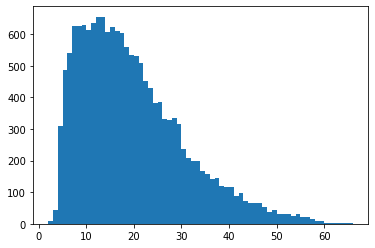

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating='post',padding='post', maxlen=maxlen)
  return padded




In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

#Labels



In [ ]:
classes = set(labels)
print(classes)

{'joy', 'fear', 'anger', 'love', 'sadness', 'surprise'}


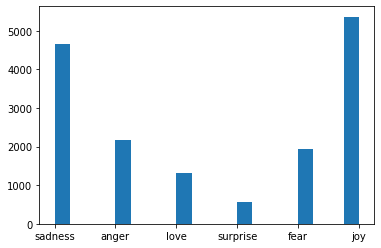

In [ ]:
plt.hist(labels, bins = 20)
plt.show()

In [ ]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())
class_to_index

{'joy': 0, 'fear': 1, 'anger': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [ ]:
index_to_class

{0: 'joy', 1: 'fear', 2: 'anger', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[1])

4


#Creating the Model



In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 16)            160000    
                                                                 
 bidirectional_27 (Bidirecti  (None, 50, 200)          93600     
 onal)                                                           
                                                                 
 bidirectional_28 (Bidirecti  (None, 200)              240800    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 495,606
Trainable params: 495,606
Non-trainable params: 0
_________________________________________________________________


#Training the Model


In [ ]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40)
    ]
)

Epoch 1/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0231 - accuracy: 0.9912 - val_loss: 0.3874 - val_accuracy: 0.9070
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0276 - accuracy: 0.9904 - val_loss: 0.3609 - val_accuracy: 0.9145
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0209 - accuracy: 0.9918 - val_loss: 0.4136 - val_accuracy: 0.9135
Epoch 4/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0178 - accuracy: 0.9926 - val_loss: 0.4285 - val_accuracy: 0.9165
Epoch 5/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0190 - accuracy: 0.9919 - val_loss: 0.3811 - val_accuracy: 0.9145
Epoch 6/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0167 - accuracy: 0.9936 - val_loss: 0.3851 - val_accuracy: 0.9190
Epoch 7/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0174 - accuracy: 0.9933 - val_loss: 0.4282 - val_accuracy: 0.9110

# Evaluating the Model

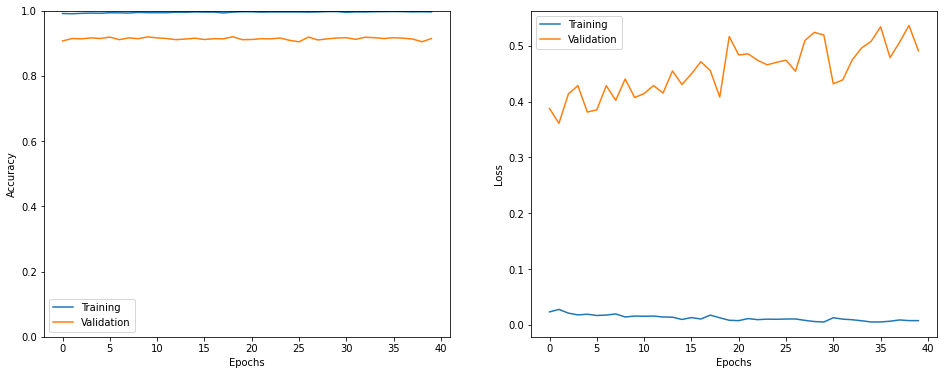

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 8ms/step - loss: 0.4987 - accuracy: 0.9060


In [ ]:
i = random.randint(10, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)


Sentence: i bought the gb iphone i got a apple store credit i feel like they were sympathetic to early buyers and responded appropriately
Emotion: love
Predicted Emotion: love


# Conclusion

Model Accuracy - 90.60%

~ Annnapoorna Sai Sriram Mandalika